<a href="https://colab.research.google.com/github/trefftzc/cis677/blob/main/Exploring_julia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installation cell
%%capture
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'
export JULIA_NUM_THREADS=2

After you run the first cell (the the cell directly above this text), go to Colab's menu bar and select **Edit** and select **Notebook settings** from the drop down. Select *Julia 1.11.1* in Runtime type. You can also select your prefered harwdware acceleration (defaults to GPU).

<br/>You should see something like this:

> ![Colab Img](https://raw.githubusercontent.com/Dsantra92/Julia-on-Colab/master/misc/julia_menu.png)

<br/>Click on SAVE
<br/>**We are ready to get going**





In [1]:
VERSION

v"1.11.1"

The following piece of code was written by Dr. William Godoy from ORNL.
The complete code is available in his github repository: https://github.com/williamfgc/simple-gemm

This initial version is a sequential version of matrix multiplication


In [2]:
import Random

@doc """
Simplified gemm: C = alpha A x B + C where alpha = 1 , C = zeros,
so:
C = A x B
"""
function gemm!(A::Array{Float32,2}, B::Array{Float32,2}, C::Array{Float32,2})

    A_rows = size(A)[1]
    A_cols = size(A)[2]
    B_cols = size(B)[2]

     for j = 1:B_cols
        for l = 1:A_cols
            @inbounds temp::Float32 = B[l, j]::Float32
            for i = 1:A_rows
                @inbounds C[i, j] += temp * A[i, l]
            end
        end
    end
end

function main(args::Array{String,1})::Int32

    # must initialize scalars
    A_rows::Int64 = -1
    A_cols::Int64 = -1
    B_rows::Int64 = -1
    B_cols::Int64 = -1

    steps::Int32 = 1

    @show args

    # args don't include Julia executable and program
    nargs = size(args)[1]

    if nargs == 4 || nargs == 3
        A_rows = parse(Int64, args[1])
        A_cols = parse(Int64, args[2])
        B_rows = parse(Int64, args[2])
        B_cols = parse(Int64, args[3])

        if nargs == 4
            steps = parse(Int32, args[4])
        end
    else
        throw(
            ArgumentError( "Usage: \n - 3 arguments: matrix A rows, matrix A cols and matrix B cols\n- 4 arguments: matrix A rows, matrix A cols and matrix B cols, steps",
            ),
        )
    end

    # Julia is column-based (like Fortran)
    @time begin

        print("Time to allocate A ")
        @time A = Array{Float32,2}(undef, A_rows, A_cols)
        print("Time to allocate B ")
        @time B = Array{Float32,2}(undef, B_rows, B_cols)
        print("Time to initialize C ")
        @time C = zeros(Float32, A_rows, B_cols)

        print("Time to fill A ")
        @time Random.rand!(A)
        print("Time to fill B ")
        @time Random.rand!(B)

        print("Time to simple gemm ")
        @time gemm!(A, B, C)

        if steps > 1
            timings = zeros(steps)
            for i = 2:steps
                print("Time to simple gemm ")
                 timings[i] = @elapsed gemm!(A, B, C)
                println(timings[i])
            end

            average_time = sum(timings) / (steps - 1)
            gflops = (2 * A_rows * A_cols * B_cols) * 1E-9 / average_time
            println(
                "GFLOPS: ",
                gflops,
                " steps: ",
                steps,
                " average_time: ",
                average_time,
            )
        end

        print("Time to total time ")
    end
    return 0

end



main(["500","500","500","5"])

args = ["500", "500", "500", "5"]
Time to allocate A   0.000018 seconds (3 allocations: 976.641 KiB)
Time to allocate B   0.000014 seconds (3 allocations: 976.641 KiB)
Time to initialize C   0.000498 seconds (3 allocations: 976.641 KiB)
Time to fill A   0.000435 seconds
Time to fill B   0.000472 seconds
Time to simple gemm   0.016965 seconds
Time to simple gemm 0.016927176
Time to simple gemm 0.018533951
Time to simple gemm 0.016544114
Time to simple gemm 0.016291692
GFLOPS: 14.641945927498679 steps: 5 average_time: 0.017074233249999998
Time to total time   0.193631 seconds (71.78 k allocations: 6.931 MiB, 54.79% compilation time)


0

This second version uses Thread parallelization.
Something similar to using OpenMP parallel loop or NUMBA's prange

In [3]:
Threads.nthreads()

1

In [4]:
import Random

@doc """
Simplified gemm: C = alpha A x B + C where alpha = 1 , C = zeros,
so:
C = A x B
"""
function gemm!(A::Array{Float32,2}, B::Array{Float32,2}, C::Array{Float32,2})

    A_rows = size(A)[1]
    A_cols = size(A)[2]
    B_cols = size(B)[2]

    Threads.@threads for j = 1:B_cols
        for l = 1:A_cols
            @inbounds temp::Float32 = B[l, j]::Float32
            for i = 1:A_rows
                @inbounds C[i, j] += temp * A[i, l]
            end
        end
    end
end

function main(args::Array{String,1})::Int32

    # must initialize scalars
    A_rows::Int64 = -1
    A_cols::Int64 = -1
    B_rows::Int64 = -1
    B_cols::Int64 = -1

    steps::Int32 = 1

    @show args

    # args don't include Julia executable and program
    nargs = size(args)[1]

    if nargs == 4 || nargs == 3
        A_rows = parse(Int64, args[1])
        A_cols = parse(Int64, args[2])
        B_rows = parse(Int64, args[2])
        B_cols = parse(Int64, args[3])

        if nargs == 4
            steps = parse(Int32, args[4])
        end
    else
        throw(
            ArgumentError( "Usage: \n - 3 arguments: matrix A rows, matrix A cols and matrix B cols\n- 4 arguments: matrix A rows, matrix A cols and matrix B cols, steps",
            ),
        )
    end

    # Julia is column-based (like Fortran)
    @time begin

        print("Time to allocate A ")
        @time A = Array{Float32,2}(undef, A_rows, A_cols)
        print("Time to allocate B ")
        @time B = Array{Float32,2}(undef, B_rows, B_cols)
        print("Time to initialize C ")
        @time C = zeros(Float32, A_rows, B_cols)

        print("Time to fill A ")
        @time Random.rand!(A)
        print("Time to fill B ")
        @time Random.rand!(B)

        print("Time to simple gemm ")
        @time gemm!(A, B, C)

        if steps > 1
            timings = zeros(steps)
            for i = 2:steps
                print("Time to simple gemm ")
                 timings[i] = @elapsed gemm!(A, B, C)
                println(timings[i])
            end

            average_time = sum(timings) / (steps - 1)
            gflops = (2 * A_rows * A_cols * B_cols) * 1E-9 / average_time
            println(
                "GFLOPS: ",
                gflops,
                " steps: ",
                steps,
                " average_time: ",
                average_time,
            )
        end

        print("Time to total time ")
    end
    return 0

end



main(["500","500","500","5"])

args = ["500", "500", "500", "5"]
Time to allocate A   0.000027 seconds (3 allocations: 976.641 KiB)
Time to allocate B   0.000045 seconds (3 allocations: 976.641 KiB)
Time to initialize C   0.000678 seconds (3 allocations: 976.641 KiB)
Time to fill A   0.000442 seconds
Time to fill B   0.000316 seconds
Time to simple gemm   0.062661 seconds (27.53 k allocations: 1.356 MiB, 70.42% compilation time)
Time to simple gemm 0.016598242
Time to simple gemm 0.015919358
Time to simple gemm 0.016035527
Time to simple gemm 0.017777441
GFLOPS: 15.07600537960115 steps: 5 average_time: 0.016582642
Time to total time   0.131580 seconds (28.20 k allocations: 4.312 MiB, 33.54% compilation time)


0

**The next three cells are for GPU benchmarking. If you are using this notebook for the first time and have GPU enabled, you can give it a try.**

### Optional GPU Experiments

In [5]:
using Pkg
Pkg.add(["BenchmarkTools", "CUDA"])
using BenchmarkTools, CUDA

if has_cuda_gpu()
  print("The GPU device is:", CUDA.device())
end

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed GPUArraysCore ─────────────── v0.2.0
   Installed Crayons ───────────────────── v4.1.1
   Installed demumble_jll ──────────────── v1.3.0+0
   Installed ColorTypes ────────────────── v0.12.0
   Installed TableTraits ───────────────── v1.0.1
   Installed Adapt ─────────────────────── v4.2.0
   Installed Scratch ───────────────────── v1.2.1
   Installed PrettyTables ──────────────── v2.4.0
   Installed DataAPI ───────────────────── v1.16.0
   Installed BenchmarkTools ────────────── v1.6.0
   Installed LLVMLoopInfo ──────────────── v1.0.0
   Installed CUDA_Driver_jll ───────────── v0.10.4+0
   Installed Tables ────────────────────── v1.12.0
   Installed HashArrayMappedTries ──────── v0.2.0
   Installed SentinelArrays ────────────── v1.4.8
   Installed StaticArrays ──────────────── v1.9.12
   Installed AbstractFFTs ──────────────── v1.5.0
   Installed InlineStrings ─────────────── v1.4.

The GPU device is:CuDevice(0)

In [6]:
mcpu = rand(2^10, 2^10)
@benchmark mcpu*mcpu

BenchmarkTools.Trial: 129 samples with 1 evaluation per sample.
 Range (min … max):  32.449 ms … 65.802 ms  ┊ GC (min … max): 0.00% … 2.28%
 Time  (median):     36.750 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.932 ms ±  7.098 ms  ┊ GC (mean ± σ):  1.96% ± 2.88%

      ▁ █▂▂▄ ▃                                                 
  ▆▆▆███████▆█▆▄▅▅▅▁▅▃▃▃▁▁▁▄▁▃▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▃▁▃▁▁▁▁▁▆▄▃ ▃
  32.4 ms         Histogram: frequency by time        62.3 ms <

 Memory estimate: 8.00 MiB, allocs estimate: 3.

In [7]:
println("The CuArrray operation should be much faster (~100 times) than the CPU implemenation.")
mgpu = cu(mcpu)
@benchmark CUDA.@sync mgpu*mgpu

The CuArrray operation should be much faster (~100 times) than the CPU implemenation.


BenchmarkTools.Trial: 8705 samples with 1 evaluation per sample.
 Range (min … max):  401.572 μs …  11.450 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     554.801 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   566.451 μs ± 242.675 μs  ┊ GC (mean ± σ):  0.27% ± 0.99%

                                 █▅▂▅                            
  ▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▆████▇▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  402 μs           Histogram: frequency by time          686 μs <

 Memory estimate: 1.22 KiB, allocs estimate: 53.

In [8]:
a = 10
b = 20
c = a + b

30

In [9]:
function add(a,b)
  return a+b
end

add (generic function with 1 method)

In [10]:
c = add(a,b)

30

In [11]:
x = 3.1416
y = 1.4142
z = add(x,y)

4.5558

Now some examples of how to use the CUDA package in Julia

Taken from: https://cuda.juliagpu.org/stable/tutorials/introduction/

In [15]:
using CUDA
N = 2^20
x_d = CUDA.fill(1.0f0, N)  # a vector stored on the GPU filled with 1.0 (Float32)
y_d = CUDA.fill(2.0f0, N)  # a vector stored on the GPU filled with 2.0

y_d .+= x_d             # increment each element of y with the corresponding element of x

1048576-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 ⋮
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0

In [16]:
using Test
@test all(Array(y_d) .== 3.0f0)

Test Passed

Let's define a function.

In [17]:
function add_broadcast!(y, x)
    CUDA.@sync y .+= x
    return
end

add_broadcast! (generic function with 1 method)

Now let's measure how long does it take to execute the function.

In [18]:
@btime add_broadcast!($y_d, $x_d)

  67.102 μs (97 allocations: 2.42 KiB)


Writing your first GPU kernel
Using the high-level GPU array functionality made it easy to perform this computation on the GPU. However, we didn't learn about what's going on under the hood, and that's the main goal of this tutorial. So let's implement the same functionality with a GPU kernel:

In [19]:
function gpu_add1!(y, x)
    for i = 1:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda gpu_add1!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

Aside from using the CuArrays x_d and y_d, the only GPU-specific part of this is the kernel launch via @cuda. The first time you issue this @cuda statement, it will compile the kernel (gpu_add1!) for execution on the GPU. Once compiled, future invocations are fast. You can see what @cuda expands to using ?@cuda from the Julia prompt.

Let's benchmark this:

In [20]:
function bench_gpu1!(y, x)
    CUDA.@sync begin
        @cuda gpu_add1!(y, x)
    end
end

bench_gpu1! (generic function with 1 method)

In [21]:
@btime bench_gpu1!($y_d, $x_d)

  54.061 ms (13 allocations: 256 bytes)


CUDA.HostKernel for gpu_add1!(CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1})

That's a lot slower than the version above based on broadcasting. What happened?

Profiling

When you don't get the performance you expect, usually your first step should be to profile the code and see where it's spending its time:

In [22]:
bench_gpu1!(y_d, x_d)  # run it once to force compilation
CUDA.@profile bench_gpu1!(y_d, x_d)

Profiler ran for 120.83 ms, capturing 793 events.

Host-side activity: calling CUDA APIs took 120.03 ms (99.34% of the trace)
┌──────────┬────────────┬───────┬─────────────────────┐
│ Time (%) │ Total time │ Calls │ Name                │
├──────────┼────────────┼───────┼─────────────────────┤
│   99.34% │  120.03 ms │     1 │ cuStreamSynchronize │
│    0.11% │  136.85 µs │     1 │ cuLaunchKernel      │
└──────────┴────────────┴───────┴─────────────────────┘

Device-side activity: GPU was busy for 120.67 ms (99.87% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────────────────────────────────────┐
│ Time (%) │ Total time │ Calls │ Name                                                                  │
├──────────┼────────────┼───────┼───────────────────────────────────────────────────────────────────────┤
│   99.87% │  120.67 ms │     1 │ gpu_add1_(CuDeviceArray<Float32, 1, 1>, CuDeviceArray<Float32, 1, 1>) │
└──────────┴────────────┴───────┴─────────

For further insight, run the profiling with the option trace=true

In [23]:
CUDA.@profile trace=true bench_gpu1!(y_d, x_d)

Profiler ran for 120.81 ms, capturing 793 events.

Host-side activity: calling CUDA APIs took 120.17 ms (99.47% of the trace)
┌─────┬───────────┬───────────┬────────┬─────────────────────┐
│  ID │     Start │      Time │ Thread │ Name                │
├─────┼───────────┼───────────┼────────┼─────────────────────┤
│  13 │  37.19 µs │  33.38 µs │      1 │ cuLaunchKernel      │
│ 789 │ 573.64 µs │ 120.17 ms │      2 │ cuStreamSynchronize │
└─────┴───────────┴───────────┴────────┴─────────────────────┘

Device-side activity: GPU was busy for 120.66 ms (99.88% of the trace)
┌────┬──────────┬───────────┬─────────┬────────┬──────┬───────────────────────────────────────────────────────────────────────┐
│ ID │    Start │      Time │ Threads │ Blocks │ Regs │ Name                                                                  │
├────┼──────────┼───────────┼─────────┼────────┼──────┼───────────────────────────────────────────────────────────────────────┤
│ 13 │ 69.62 µs │ 120.66 ms │       1 │ 

# Writing a parallel GPU kernel
To speed up the kernel, we want to parallelize it, which means assigning different tasks to different threads. To facilitate the assignment of work, each CUDA thread gets access to variables that indicate its own unique identity, much as Threads.threadid() does for CPU threads. The CUDA analogs of threadid and nthreads are called threadIdx and blockDim, respectively; one difference is that these return a 3-dimensional structure with fields x, y, and z to simplify cartesian indexing for up to 3-dimensional arrays. Consequently we can assign unique work in the following way:

In [24]:
function gpu_add2!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda threads=256 gpu_add2!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

Note the threads=256 here, which divides the work among 256 threads numbered in a linear pattern. (For a two-dimensional array, we might have used threads=(16, 16) and then both x and y would be relevant.)

Now let's try benchmarking it:

In [25]:
function bench_gpu2!(y, x)
    CUDA.@sync begin
        @cuda threads=256 gpu_add2!(y, x)
    end
end

bench_gpu2! (generic function with 1 method)

In [26]:
@btime bench_gpu2!($y_d, $x_d)

  1.458 ms (13 allocations: 256 bytes)


CUDA.HostKernel for gpu_add2!(CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1})

Much better!

But obviously we still have a ways to go to match the initial broadcasting result. To do even better, we need to parallelize more. GPUs have a limited number of threads they can run on a single streaming multiprocessor (SM), but they also have multiple SMs. To take advantage of them all, we need to run a kernel with multiple blocks. We'll divide up the work like this:

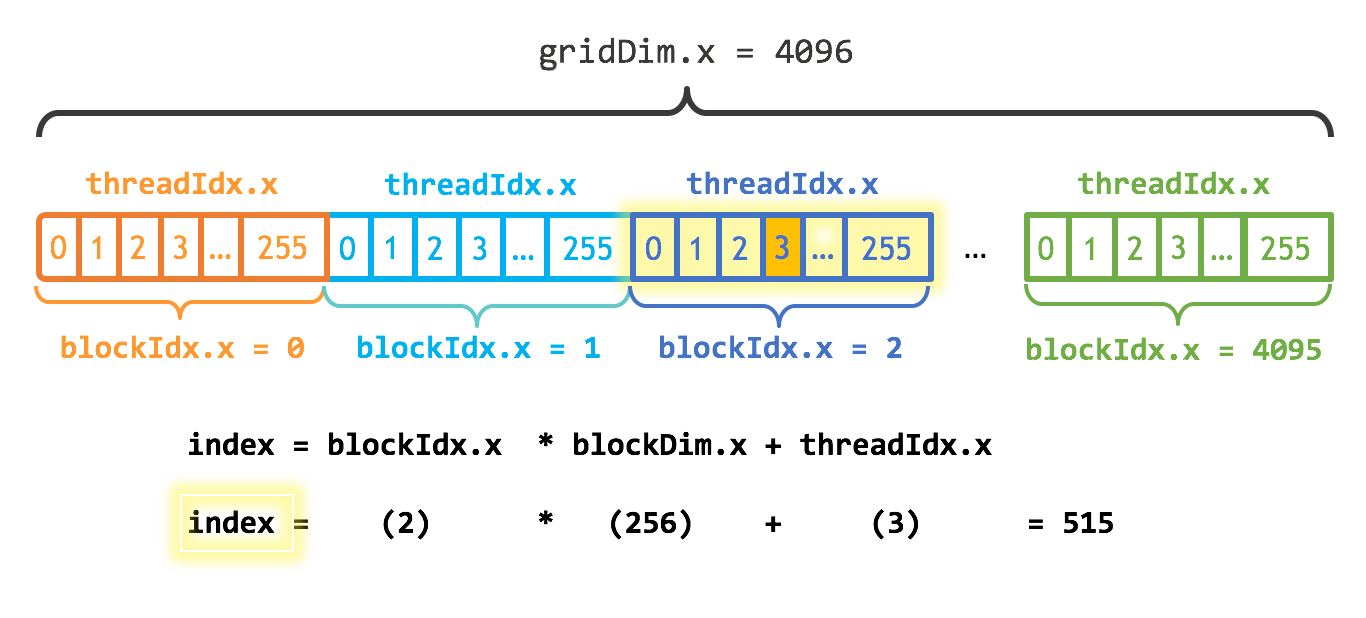

This diagram was borrowed from a description of the C/C++ library; in Julia, threads and blocks begin numbering with 1 instead of 0. In this diagram, the 4096 blocks of 256 threads (making 1048576 = 2^20 threads) ensures that each thread increments just a single entry; however, to ensure that arrays of arbitrary size can be handled, let's still use a loop:

In [27]:
function gpu_add3!(y, x)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return
end

numblocks = ceil(Int, N/256)

fill!(y_d, 2)
@cuda threads=256 blocks=numblocks gpu_add3!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [28]:
function bench_gpu3!(y, x)
    numblocks = ceil(Int, length(y)/256)
    CUDA.@sync begin
        @cuda threads=256 blocks=numblocks gpu_add3!(y, x)
    end
end

bench_gpu3! (generic function with 1 method)

In [29]:
@btime bench_gpu3!($y_d, $x_d)

  62.043 μs (12 allocations: 240 bytes)


CUDA.HostKernel for gpu_add3!(CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1})

Finally, we've achieved the similar performance to what we got with the broadcasted version. Let's profile again to confirm this launch configuration:

In [30]:
CUDA.@profile trace=true bench_gpu3!(y_d, x_d)

Profiler ran for 201.7 µs, capturing 123 events.

Host-side activity: calling CUDA APIs took 78.2 µs (38.77% of the trace)
┌─────┬───────────┬──────────┬─────────────────────┐
│  ID │     Start │     Time │ Name                │
├─────┼───────────┼──────────┼─────────────────────┤
│  13 │  61.75 µs │ 37.43 µs │ cuLaunchKernel      │
│ 119 │ 189.07 µs │   3.1 µs │ cuStreamSynchronize │
└─────┴───────────┴──────────┴─────────────────────┘

Device-side activity: GPU was busy for 70.57 µs (34.99% of the trace)
┌────┬──────────┬──────────┬─────────┬────────┬──────┬───────────────────────────────────────────────────────────────────────┐
│ ID │    Start │     Time │ Threads │ Blocks │ Regs │ Name                                                                  │
├────┼──────────┼──────────┼─────────┼────────┼──────┼───────────────────────────────────────────────────────────────────────┤
│ 13 │ 97.27 µs │ 70.57 µs │     256 │   4096 │   44 │ gpu_add3_(CuDeviceArray<Float32, 1, 1>, CuDeviceArra

In the previous example, the number of threads was hard-coded to 256. This is not ideal, as using more threads generally improves performance, but the maximum number of allowed threads to launch depends on your GPU as well as on the kernel. To automatically select an appropriate number of threads, it is recommended to use the launch configuration API. This API takes a compiled (but not launched) kernel, returns a tuple with an upper bound on the number of threads, and the minimum number of blocks that are required to fully saturate the GPU:

In [31]:
kernel = @cuda launch=false gpu_add3!(y_d, x_d)
config = launch_configuration(kernel.fun)
threads = min(N, config.threads)
blocks = cld(N, threads)

1024

The compiled kernel is callable, and we can pass the computed launch configuration as keyword arguments:

In [32]:
fill!(y_d, 2)
kernel(y_d, x_d; threads, blocks)
@test all(Array(y_d) .== 3.0f0)

Test Passed

Benchmarking:

In [33]:
function bench_gpu4!(y, x)
    kernel = @cuda launch=false gpu_add3!(y, x)
    config = launch_configuration(kernel.fun)
    threads = min(length(y), config.threads)
    blocks = cld(length(y), threads)

    CUDA.@sync begin
        kernel(y, x; threads, blocks)
    end
end

bench_gpu4! (generic function with 1 method)

In [34]:
@btime bench_gpu4!($y_d, $x_d)

  66.233 μs (22 allocations: 400 bytes)
